# Gridding Tests

This is a notenbook to test the regridding of ETOPO1 to the NEMO bathymetry as well as gridding of observations data.

In [2]:
%matplotlib inline

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.basemap import Basemap

modpath = os.path.abspath(os.path.join('/home/chrenkl/Projects/MDT_tilt/Python'))
if modpath not in sys.path:
    sys.path.append(modpath)

import nemo_tools as nt
from create_bathymetry import read_etopo, etopo2nemo

In [3]:
# project directory
projdir = '/home/chrenkl/Projects/nemo_bathymetry'

# NEMO configuration
conf = 'GoMSS'

In [11]:
# read NEMO grid
NEMO = nt.nemo_grid(os.path.join(projdir, 'data/raw', conf,
                                 'Configuration',
                                 'coordinates.nc'))
# read ETOPO data
ETOPO = read_etopo(os.path.join(projdir, 'data/external/ETOPO1',
                                'ETOPO1_Bed_g_gmt4.grd'),
                   lonmin=NEMO['lonmin'], lonmax=NEMO['lonmax'],
                   latmin=NEMO['latmin'], latmax=NEMO['latmax'])

# file name of cleaned and corrected insitu data
#ginsitufile = os.path.join(projdir, 'data/interim/gridded_in-situ.npz')
    
#gridInSitu = np.load(ginsitufile)

# create map projection for interpolations
proj = Basemap(projection='merc',
               llcrnrlat=NEMO['latmin'], urcrnrlat=NEMO['latmax'],
               llcrnrlon=NEMO['lonmin'], urcrnrlon=NEMO['lonmax'],
               resolution='h')

Read NEMO coordinates.nc file.
Read ETOPO data.


In [6]:
# interpolate ETOPO to NEMO grid
ETOPOint = etopo2nemo(NEMO, ETOPO)

Interpolate ETOPO data to NEMO grid.


In [7]:
# read NEMO bathymetry
NEMObat = nt.nemo_bathy(os.path.join(projdir, 'data/processed/bathy_meter.nc'))

Read NEMO bathy_meter.nc file.


In [8]:
# indices of cross-section
imin = 430
imax = 565
jj = 100

# extract coordinates of cross-section
cslon = NEMO.glamt.values[jj, imin:imax]
cslat = NEMO.gphit.values[jj, imin:imax]

ETOPOintcs = ETOPOint['depth'][jj, imin:imax]
NEMObatcs = NEMObat['Bathymetry'][jj, imin:imax]
gobscs = gridInSitu['depth'][jj, imin:imax]

NameError: name 'gridInSitu' is not defined

In [9]:
# file name of cleaned and corrected insitu data
insitufile = os.path.join(projdir, 'data/interim/in-situ_corrected.h5')

InSitu = pd.read_hdf(insitufile, 'InSitu')

InSitu = InSitu[(InSitu.lon >= NEMO['glamt'][jj, imin:imax].values.min()) & \
                (InSitu.lon <= NEMO['glamt'][jj, imin:imax].values.max()) & \
                (InSitu.lat >= NEMO['gphit'][jj, imin:imax].values.min()) & \
                (InSitu.lat <= NEMO['gphit'][jj, imin:imax].values.max())]

InSitu.head()

,lon,lat,depth
9282741,-58.826119,44.059168,-110.7
9282742,-58.825119,44.064168,-110.7
9282743,-58.824119,44.069167,-110.7
9282744,-58.824119,44.075167,-106.7
9282745,-58.822120,44.079167,-106.7


In [12]:
xnemo, ynemo = proj(cslon, cslat)

xtmp, ytmp = np.meshgrid(ETOPO.x.values, ETOPO.y.values)
xetopo, yetopo = proj(xtmp, ytmp)

xobs, yobs = proj(InSitu.lon.values, InSitu.lat.values)

ncs = len(xnemo)

ETOPOcs = np.zeros(ncs)
obs = pd.DataFrame()

for ii in np.arange(ncs):
    ind = np.sqrt((xnemo[ii] - xetopo)**2 + (ynemo[ii] - yetopo)**2).argmin()
    ETOPOcs[ii] = -ETOPO.z.values.ravel()[ind]
    
    dst = np.sqrt((xnemo[ii] - xobs)**2 + (ynemo[ii] - yobs)**2)    
    obs = obs.append(InSitu[dst <= 1000.])
    

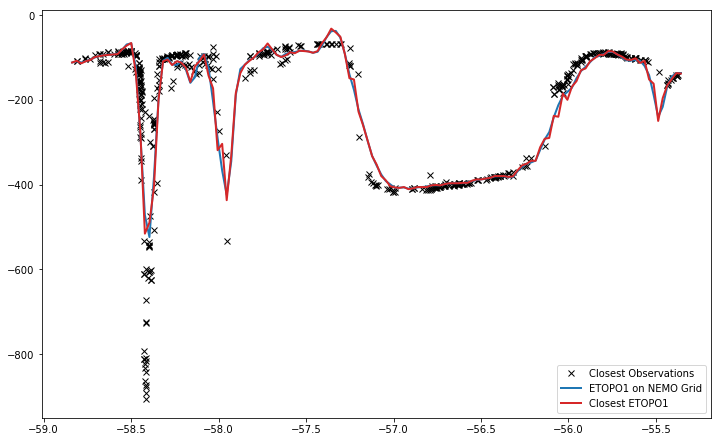

In [14]:
# Figure 1:
# -------------------------------------------------------------------------

# create figure        
fig, ax = plt.subplots(1, 1, figsize=(12, 7.5))

ax.plot(obs.lon, obs.depth,
        'x', color='k', linewidth=2, label='Closest Observations')

ax.plot(cslon, np.ma.masked_where(-ETOPOintcs >= 0., -ETOPOintcs),
        '-', color='C0', linewidth=2, label='ETOPO1 on NEMO Grid')

ax.plot(cslon, np.ma.masked_where(-ETOPOcs >= 0., -ETOPOcs),
        '-', color='C3', linewidth=2, label='Closest ETOPO1')

#ax.plot(cslon, np.ma.masked_where(-gobscs >= 0., -gobscs),
##        '-', color='C3', linewidth=2, label='Gridded Observations')

#ax.plot(cslon, np.ma.masked_where(-NEMObatcs >= 0., -NEMObatcs),
#        '--', color='C2', linewidth=2, label='OI Bathymetry')

ax.legend(loc=4)